# Example of using TSP solver (DEAP library) for optimum node Assignments

Description of the Algorithm: 

Assuming a DAG I am going to use the following quantities:
1. __Parameters__: a) DAG, b) Specifics of the EA solver, e.g. Ngen (generations), c) Npop (number of individuals in population) etc 
2. __thread_spead__: This is an array of length *Nnodes*, i.e. equal to the total number of nodes in the Graph. The point is that since Number_of_nodes >> Number_of_threads, I will use slices of the DAG, to assign in the threads. 
3. __node_volume__: Array of length *Nnodes*. It represents the volume of data (in GB) to be processed. 
3. __node_load__: This is an array of length *Nnodes*. It represents the work that needs to be done on this node. The processing time then, for node i, which is assigned thread j is:
4. <del>__processing_times__]: Matrix(*Nnodes*,*Nnodes*). Definition __processing_times__(i,j) = __node_load__(i)/__thread_speed__(j) . It represents the time required for thread j to process node i.</del> 
5. __thread_traffic__: Matrix (dense) of length (Nnodes,Nnodes). It represents the speed for transfering information from __thread__(i) to __thread__(j)
6. __transfer_time__ (i,j,k): Scalar. It represents the time required to transfer data from thread(i) to thread(j), assuming that in thread(i) has been assigned node(k). This will be evaluated on the fly (probably), or else it should be represented in a dense 3 dimensional tensor format. 

In [1]:
import seaborn # cool plots 
import matplotlib.pyplot as plt

import random # Setting seed operations 
import operator
import time # Timing the operation 

import numpy as np # we all know this usual suspect ... 

from scipy import sparse as sp # necessary for representation of sparse matrices. 
import itertools # Need it for iterating over sparse matrix


# EA specifics, from the DEAP EA library. 
from deap import algorithms, base, creator, tools

import pickle # Write logging data to file 

random.seed(0) # planting a random seed for reproducibility 

In [8]:
# *************************** PARAMETERS **********************************

Nnodes = 100
# Read file with parameters 
lb_file = "logbook.dat" # Write here statistics 
best_file="best_individual" # Write here best individual after termination 


Npop = 100  # Can change this / read from parameter file  
Ngen = 500  # Read from parameters file 

# Got really nice results with these values 
cxpb=0.7
mutpb=0.01

# ************************************************************************

In [9]:
# ********************************************************************************
############################# READ ONLY VARIABLES ##############################
thread_speed = np.random.random(Nnodes)
node_volume = np.random.random(Nnodes)
node_load = np.random.random(Nnodes)
#processing_times = numpy.outer(node_load,1.0/thread_speed) # Will not use 
thread_traffic = np.random.rand(Nnodes,Nnodes)


# Specifics of creating a random DAG_AdMatrix
# Creator of random sparse matrix filled with ones in the nonzero elements.
density = 1.0/float(Nnodes)
DAG_AdjMatrix=sp.rand(Nnodes,Nnodes,density=density,format='coo')
DAG_AdjMatrix.data[:]=1
# ********************************************************************************

In [10]:
############## EA SPECIFIC DEFINITIONS ######################################
# DEAP specifics 
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("indices", np.random.permutation, Nnodes)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)


# ************** MOST IMPORTANT: Specific Crossover and Mutation operators ********************
# Crossover: CX crossover
# Mutation: Shuffle cities arrangement at random
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3) # good choice 
# ********************************************************************************************

In [11]:
# This is my fitness function 
def FitFunc(individual):
    '''
    This function takes in a DAG, and a permutation of the array of nodes, and results
    an overall time for a given DAG. The DAG_AjdMatrix is good to  be in upper triangular form,
    is this a topological sort? 
    perm: individual
    DAG_AdjMatrix: the initial Adjucent matrix of the DAG. 
    '''
    # perm = np.array(individual) # Try to define the EA with numpy arrays instead, to avoid casting on run time 
    # DAG_AdjMatrix : Scipy Sparse matrix csr 
    # permutation: an array of integers that consists of a random shaffling 
    process_time_total = np.sum(node_load / thread_speed[individual])

    ########################## MAYDAY HERE!!!! ###############################
    # Summing allong each ROW, this follows from the AdjMatrix definition
    transfer_time_total = np.sum([ node_volume[i]/thread_traffic[individual[i],individual[j]]
                                for i,j  in itertools.izip(DAG_AdjMatrix.row,
                                                           DAG_AdjMatrix.col)])


    total_time =  process_time_total + transfer_time_total

    # if CONDITION MET: 
    # Write Best individual in file
    # Write statistics in file 
    # exit the code 
    # quit(); 

    """
    if ( total_time <= threshold):
        best_individual = tools.selBest(result, k=1)[0]
        pickle.dump(best_individual,best_file)
        pickle.dump(log, lb_file)
        quit(); 
    """

    return (total_time,) # The tuple format has to do with EA internals (ready for MO-opt). 

toolbox.register("evaluate", FitFunc)


In [12]:
# Statistics of the fitness
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)
fit_stats.register('max', np.max)
fit_stats.register('var', np.var)

In [13]:
def run_EA_wthStats():
    result, log = algorithms.eaSimple(toolbox.population(n=Npop), toolbox,
                                  cxpb=cxpb, mutpb=mutpb,
                                  ngen=Ngen, verbose=False,
                                  stats=fit_stats)
    return result,log


In [14]:
start_time = time.time();
result, log = run_EA_wthStats();
end_time = time.time();

Displaying solution, time duration, min/max/mean values of fitness for each generation

Duration --- 15.8080401421 seconds ---


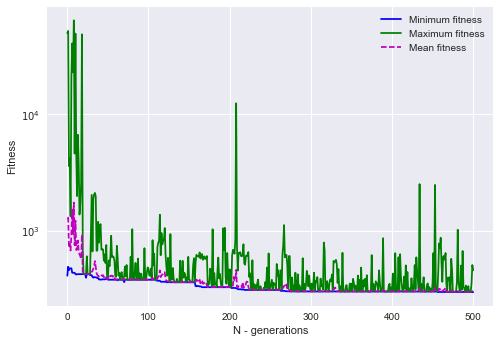

In [34]:
print ("Duration --- %s seconds ---" % (end_time - start_time))

best_individual = tools.selBest(result, k=1)[0]
#pickle.dump(best_individual,best_file)
#pickle.dump(log, lb_file)


# And do some nice plots 
plt.figure(1)
plots = plt.plot(log.select('min'),'b-', log.select('max'),'g-', log.select('mean'), 'm--', antialiased=True)
plt.legend(plots, ('Minimum fitness','Maximum fitness',   'Mean fitness'))
plt.ylabel('Fitness')
plt.xlabel('N - generations')
plt.yscale('symlog')


plt.show()


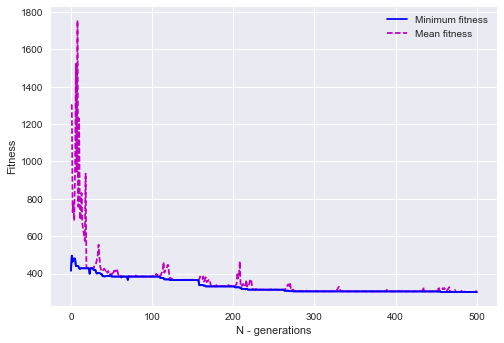

In [35]:
plots = plt.plot(log.select('min'),'b-',  log.select('mean'), 'm--', antialiased=True)
plt.legend(plots, ('Minimum fitness',   'Mean fitness'))
plt.ylabel('Fitness')
plt.xlabel('N - generations')
#plt.yscale('symlog')
plt.plot(log.select('min'),'b-')
plt.show()

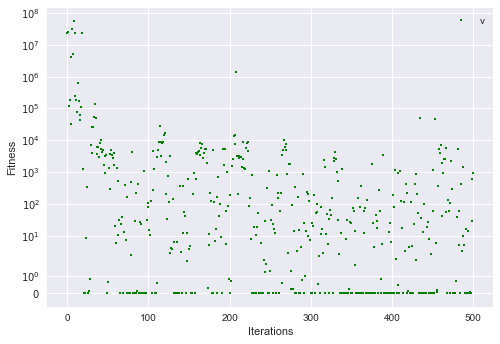

In [43]:
plots = plt.plot(log.select('var'),'gs',ms=2, antialiased=True)
plt.legend(plots, ('variance'))
plt.ylabel('Fitness')
plt.xlabel('Iterations')
plt.yscale('symlog')
plt.show()